# Data Preparation

The quality and size of the data trump the algorithm or model architecture. One of the most impactful quality advances has been identifying the best training data subset to use, including the selection of important features and observations. Many identified errors we encountered in the implementation process could be traced back to issues with the input data. Incorrect data may cause the model to learn the wrong patterns, regardless of what modelling techniques we try.

The data structure of our datasets shows that compounds are provided in the form of chemical names and Simplified Molecular Input Line Entry System (SMILES). SMILES is a specification of a line notation for representing chemical structures in a compact and human-readable form. David Weininger initiated the original SMILES specification in the 1980s.

In [1]:
import sys

sys.path.insert(0, '..')

In [2]:
from data.dataset import Dataset
from data.featurization.base import BaseRepresentation
import pandas as pd
import ipyplot
import numpy as np
import itertools

## 1 Load Datasets

Simple models on large data sets generally beat fancy models on small data sets. A training dataset of known intrinsic aqueous solubility is prepared from the following sources for regression problems: 2008 Solubility Challenge training set, 2019 Solubility Challenge training set, DLS-100, Bergström et al. (2004), Wassvik et al. (2006), AqSolDB and ESOL Drug Solubility Challange (2004). Prior to performing any data preprocessing, the dataset comprises information on a total of 11,453 compounds.

In [3]:
SC18_TRN = Dataset.from_excel(excel_path="csv/2008SC-94.xlsx", X_name="SMILES", y_name="LogS exp (mol/L)",
                              ID_name="Chemical name")
SC19_TRN = Dataset.from_excel(excel_path="csv/SC19_trn.xlsx", X_name="SMILES", y_name="LogS exp (mol/L)",
                              ID_name="Chemical name")
HUG = Dataset.from_excel(excel_path="csv/HUG.xlsx", X_name="SMILES", y_name="LogS exp (mol/L)", ID_name="Chemical name")
KAG = Dataset.from_excel(excel_path="csv/KAG.xlsx", X_name="SMILES", y_name="LogS exp (mol/L)", ID_name="Chemical name")
OTR = Dataset.from_excel(excel_path="csv/OTR.xlsx", X_name="SMILES", y_name="LogS exp (mol/L)", ID_name="Chemical name")
CSD = Dataset.from_csv(csv_path="csv/CSD.csv", X_name="SMILES", y_name="LogS exp (mol/L)", ID_name="Chemical name")

In [4]:
print(f"SC18_TRN: {len(SC18_TRN)}")
print(f"SC19_TRN: {len(SC19_TRN)}")
print(f"HUG: {len(HUG)}")
print(f"KAG: {len(KAG)}")
print(f"OTR: {len(OTR)}")
print(f"CSD: {len(CSD)}")

SC18_TRN: 94
SC19_TRN: 153
HUG: 73
KAG: 984
OTR: 7
CSD: 9982


## 2 Take a Quick Look at the Data Structure

The data structure of our datasets shows that compounds are provided in the form of chemical names and Simplified Molecular Input Line Entry System (SMILES). Since we used multiple datasets for training and evaluating our machine learning model, first, let's take a quick look at the molecules - do the compounds from the different datasets look significantly different?

In [5]:
import rdkit
from rdkit.Chem.Draw import MolToImage

compounds_per_set = 10


def smiles_to_image(smiles: list[str]):
    img = []
    for s in smiles:
        mol = rdkit.Chem.MolFromSmiles(s)
        if mol is None:
            continue
        rdkit.Chem.Kekulize(mol)
        img.append(np.array(MolToImage(mol, fitImage=True)))
    return img

We randomly pick 10 compounds from each dataset and visualize them using an interactive widget.


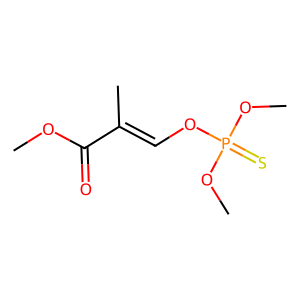
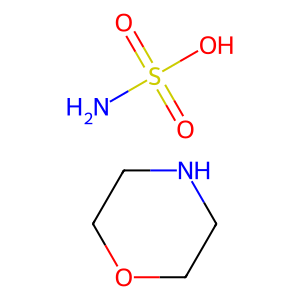
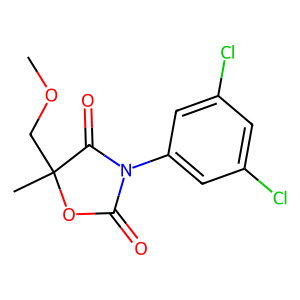
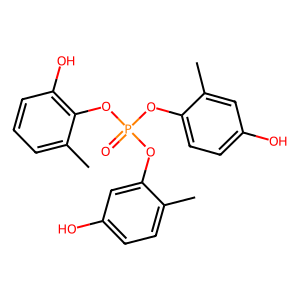
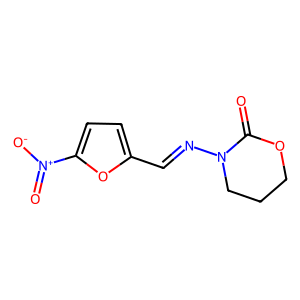
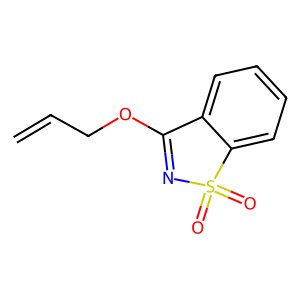
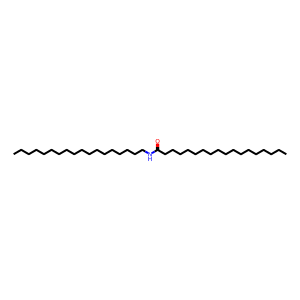
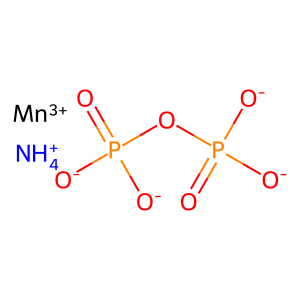
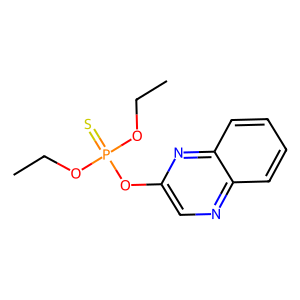
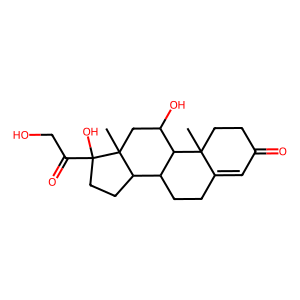
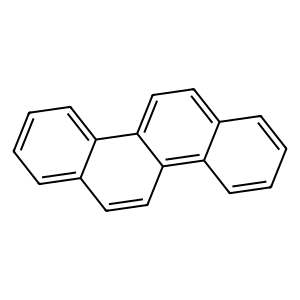
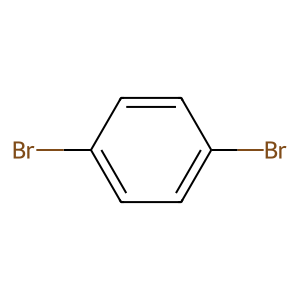
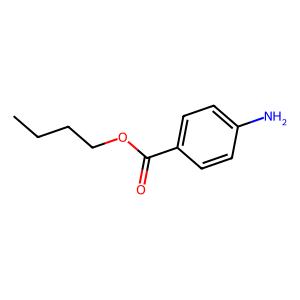
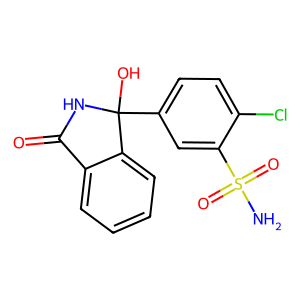
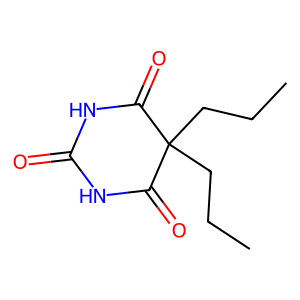
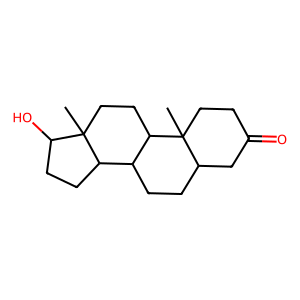
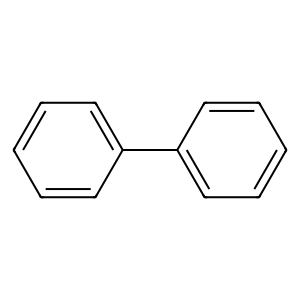
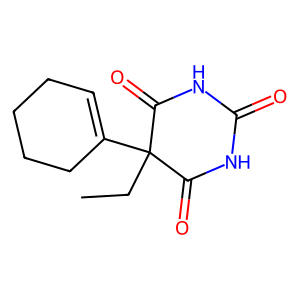
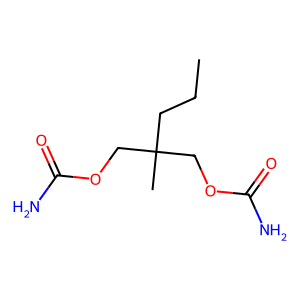
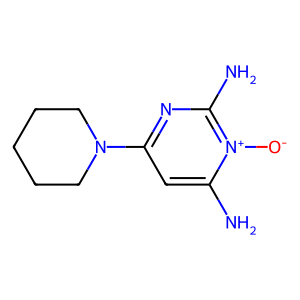
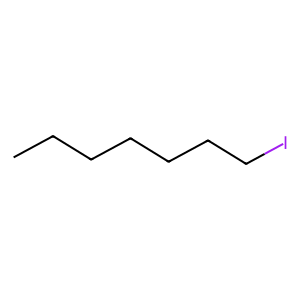
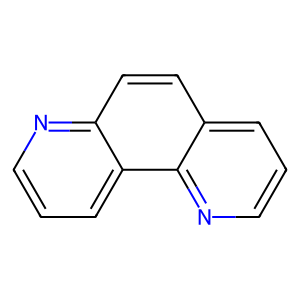
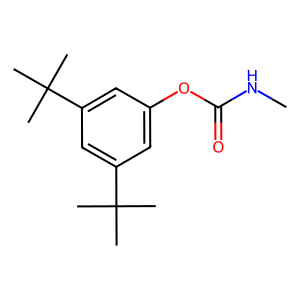
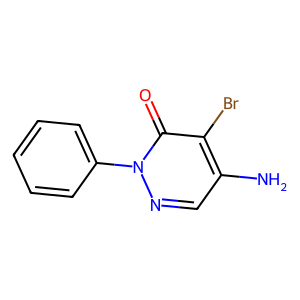
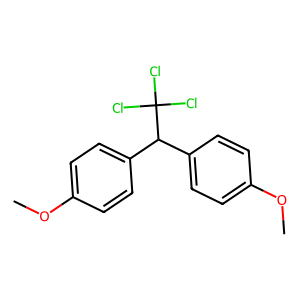
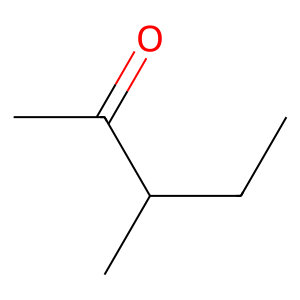
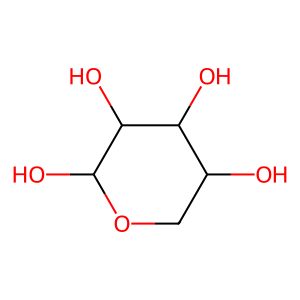
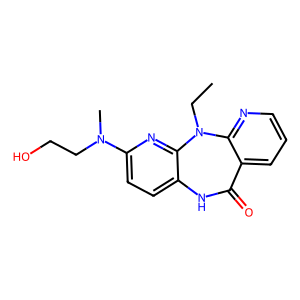
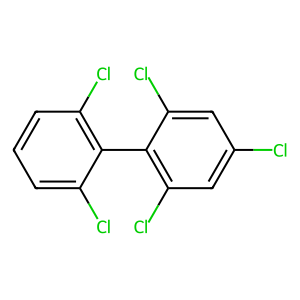
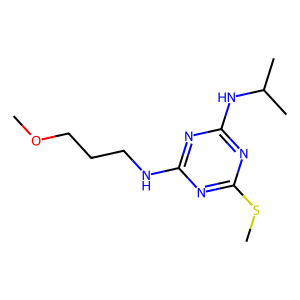
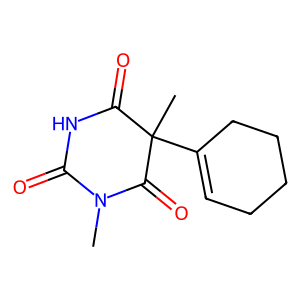
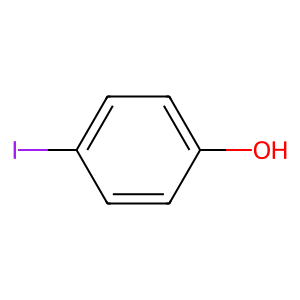
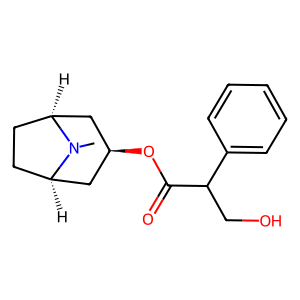
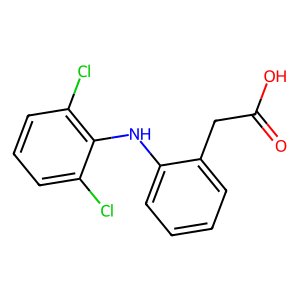
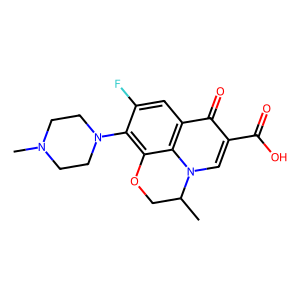
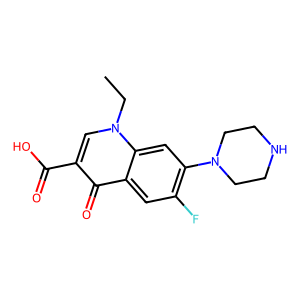
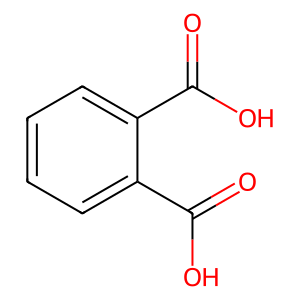
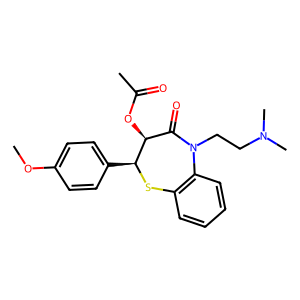
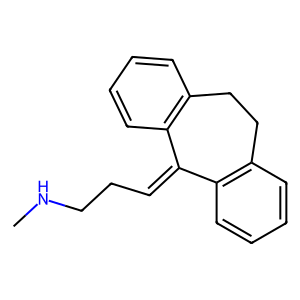
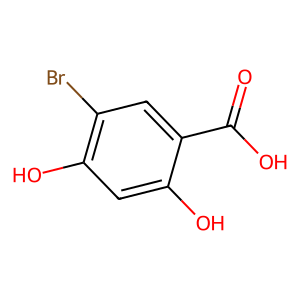
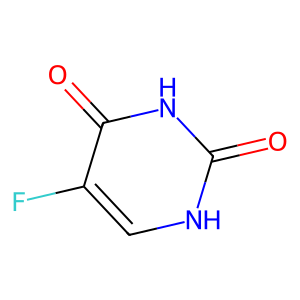
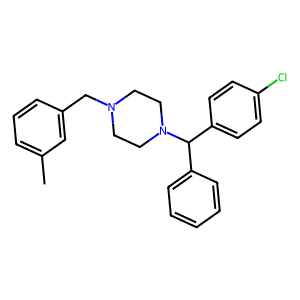
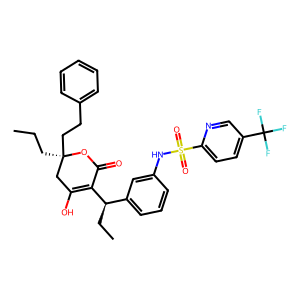
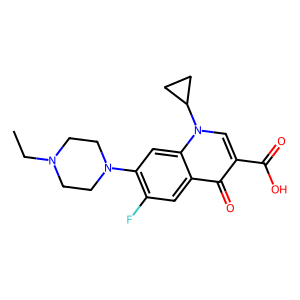
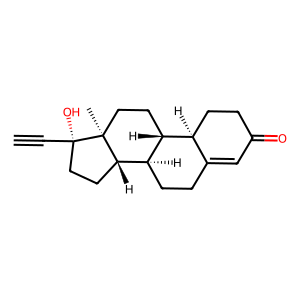
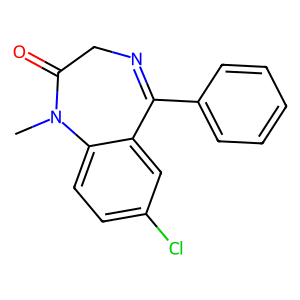
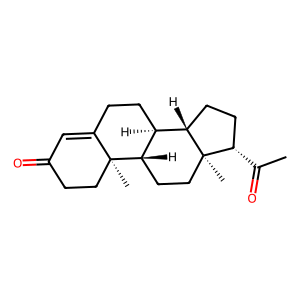
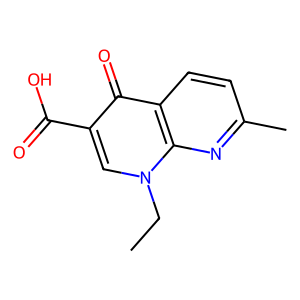
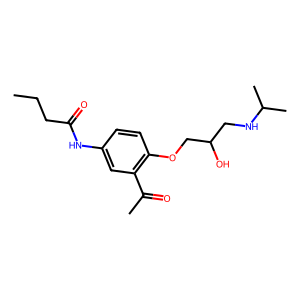
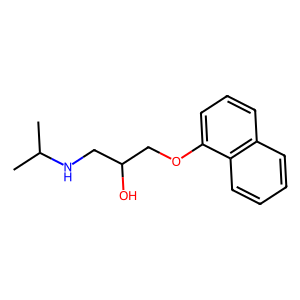


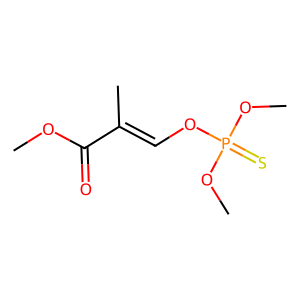
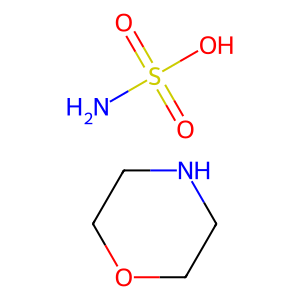
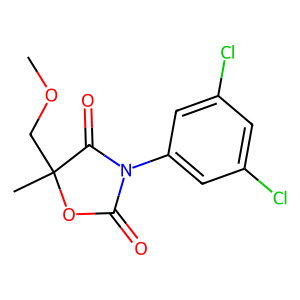
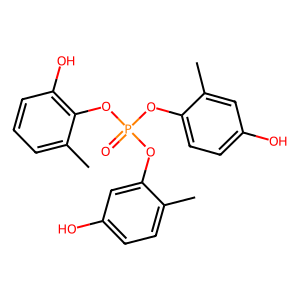
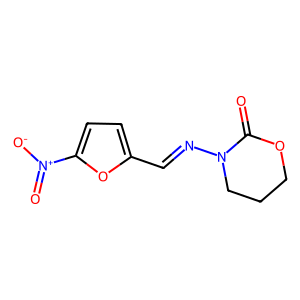
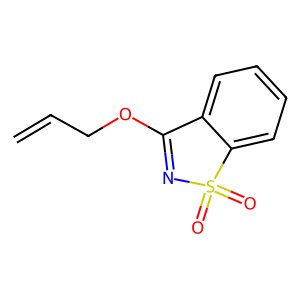
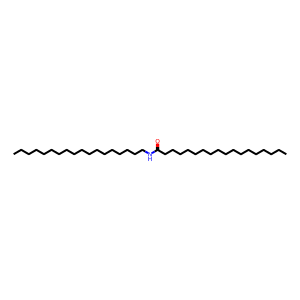
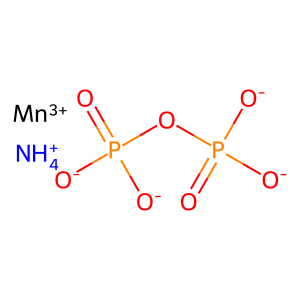
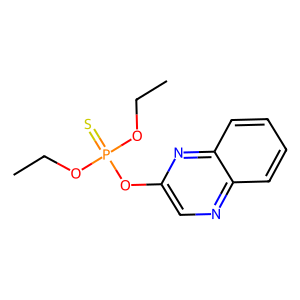
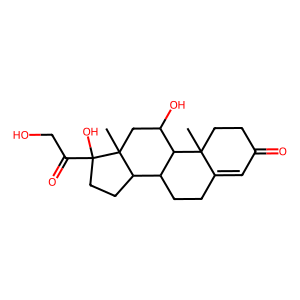
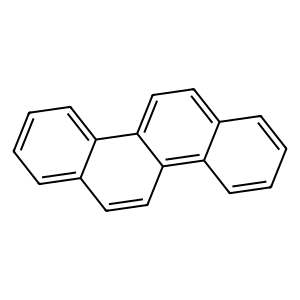
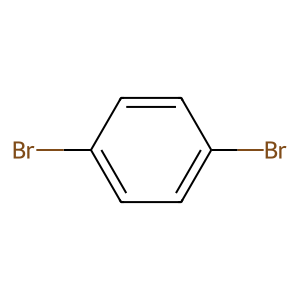
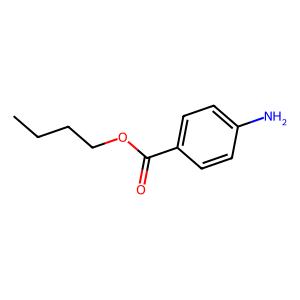
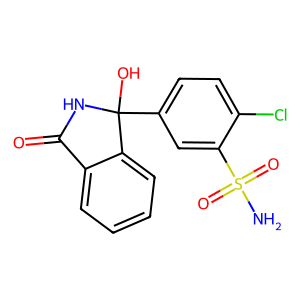
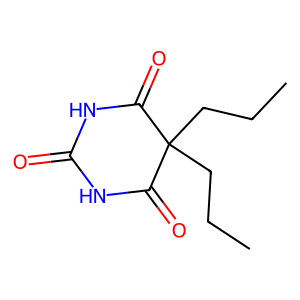
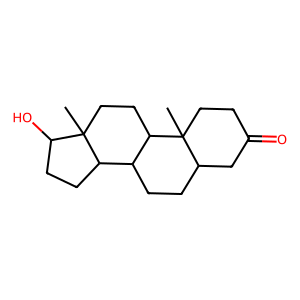
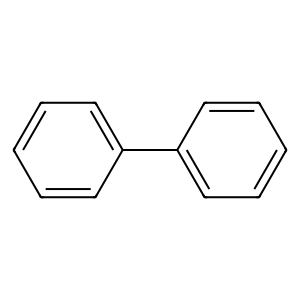
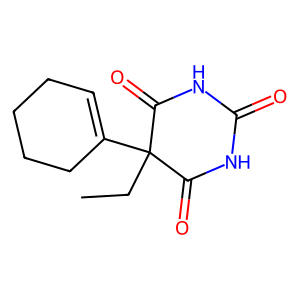
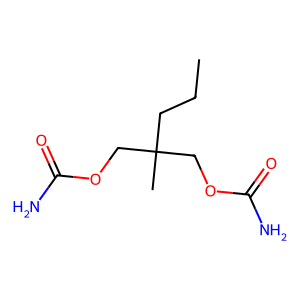
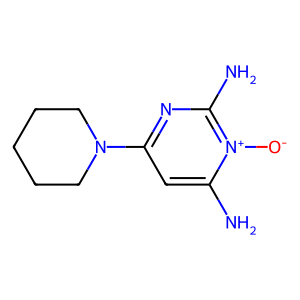
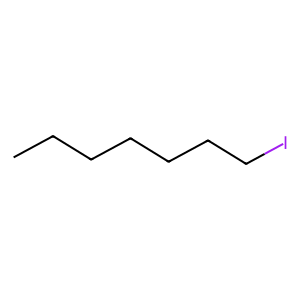
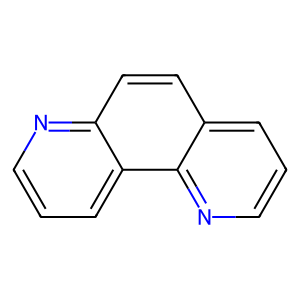
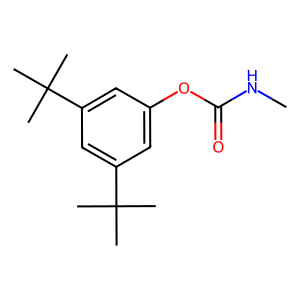
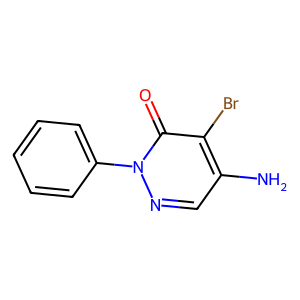
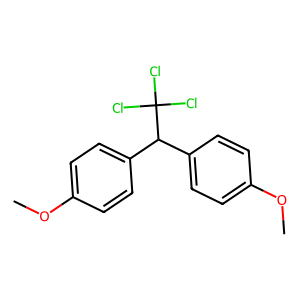
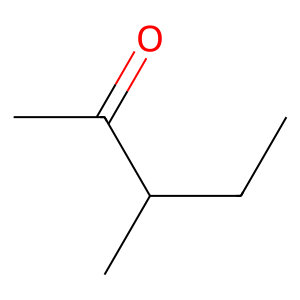
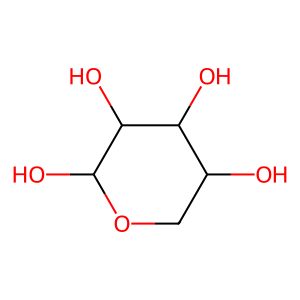
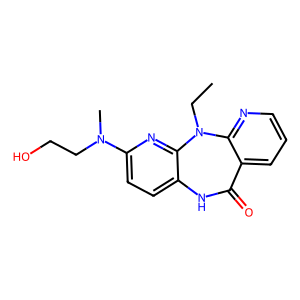
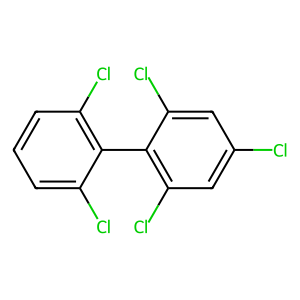
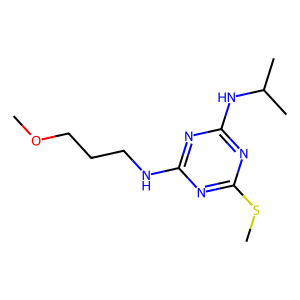
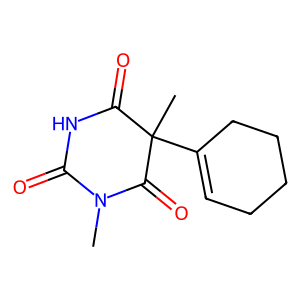
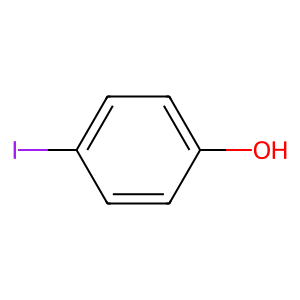
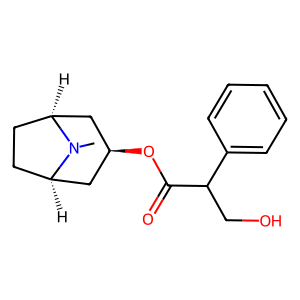
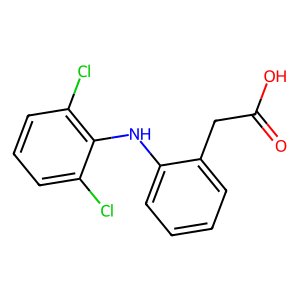
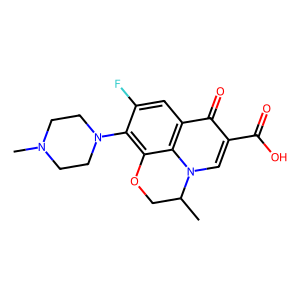
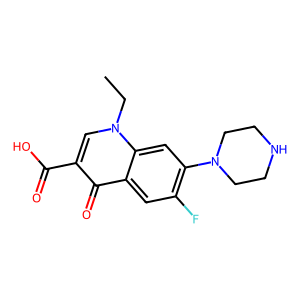
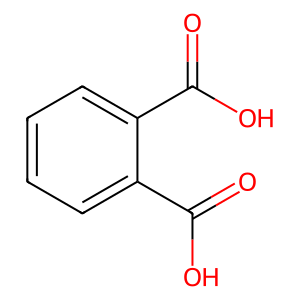
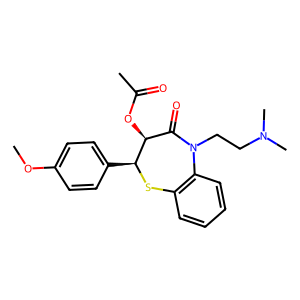
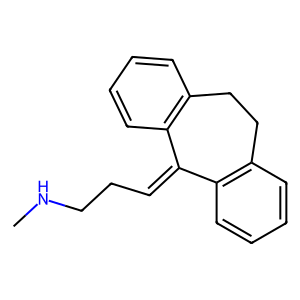
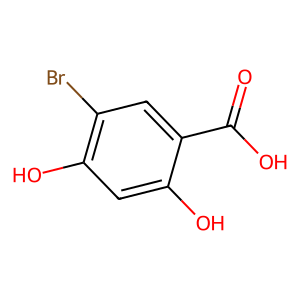
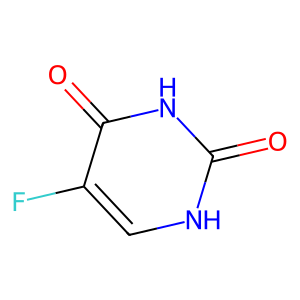
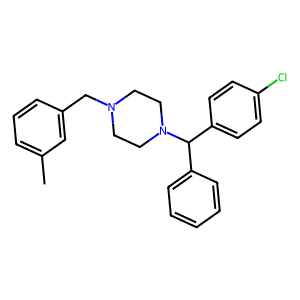
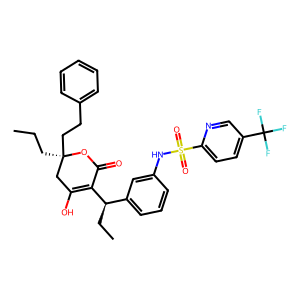
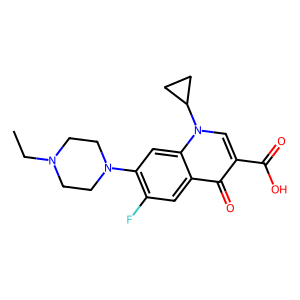
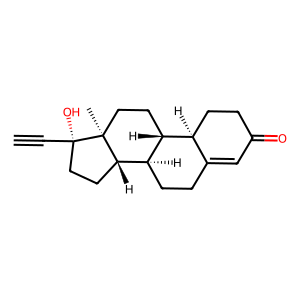
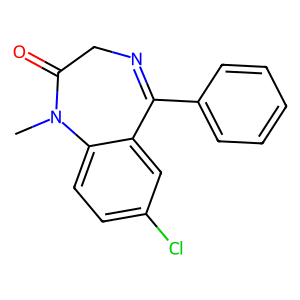
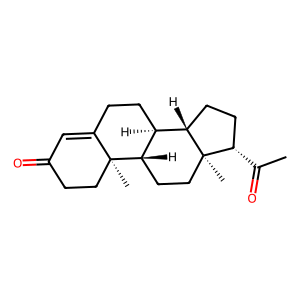
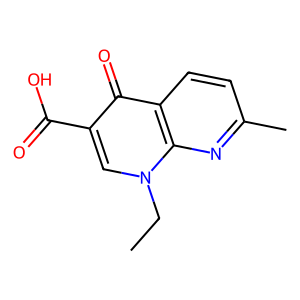
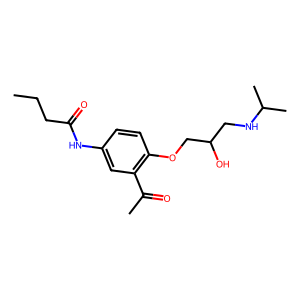
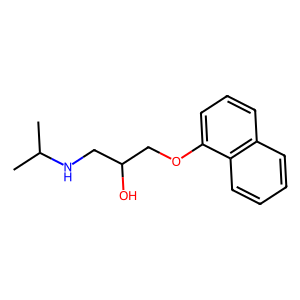

In [6]:
compound_img = {
    "SC19_TRN": smiles_to_image(SC19_TRN.X.sample(compounds_per_set)["SMILES"]),
    "SC18_TRN": smiles_to_image(SC18_TRN.X.sample(compounds_per_set)["SMILES"]),
    "HUG": smiles_to_image(HUG.X.sample(compounds_per_set)["SMILES"]),
    "KAG": smiles_to_image(KAG.X.sample(compounds_per_set)["SMILES"]),
    "CSD": smiles_to_image(CSD.X.sample(compounds_per_set)["SMILES"])
}

ipyplot.plot_class_tabs(
    images=list(itertools.chain(compound_img.values())),
    labels=[compounds_per_set * [label] for label in compound_img.keys()]
)

These images show some variation in compounds from different datasets.

## 3 Combine multiple datasets

We concatenate different datasets to form two training sets of different sizes. Specifically,

- `TRN`: (9982 Compounds) A larger dataset containing `SC19_TRN`, `HUG`, `KAG`, `OTR` and `CSD`

In [7]:
TRN_X = pd.concat([SC19_TRN.X, SC18_TRN.X, HUG.X, KAG.X, OTR.X])
TRN_y = pd.concat([SC19_TRN.y, SC18_TRN.y, HUG.y, KAG.y, OTR.y])
TRN_ID = pd.concat([SC19_TRN.ID, SC18_TRN.ID, HUG.ID, KAG.ID, OTR.ID])
TRN_Xy = pd.concat([TRN_X, TRN_y, TRN_ID], axis=1)
TRN_Xy = TRN_Xy.drop_duplicates(subset="SMILES", keep="first")
TRN = Dataset(X=TRN_Xy["SMILES"], y=TRN_Xy["LogS exp (mol/L)"], ID=TRN_Xy["Chemical name"])
TRN.save_csv("ds/TRN")
del TRN_X, TRN_y, TRN_Xy

In [8]:
TST = Dataset.from_excel(excel_path="csv/2008SC-28.xlsx", X_name="SMILES", y_name="LogS exp (mol/L)",
                         ID_name="Chemical name")
TST.save_csv("ds/TST")

Reload from the disk.

In [9]:
TRN = Dataset.load_csv("ds/TRN")
TST = Dataset.load_csv("ds/TST")

## 4 Data Cleaning

### 4.1 Handling Missing Values

Like many other real world datasets, our datasets contain missing values, which however are incompatible with most of the Machine Learning models which assume that all values hold meaning. We do not have a standard strategy to impute the missing SMILES, so we discard entire observations containing missing values. However, this comes at the price of losing data which may be valuable.

In [10]:
print(f"TRN has missing values: {True in TRN.X.isnull().sum() != 0}")

TRN has missing values: False


### 4.2 Duplicate Checking

Unlike InChel, which aims to provide a unique identifier for chemical structures, there is no standard for generating a canonical SMILES string. O’Boyle presents a standard method to generate canonical SMILES based on the InChI [1], but SMILES provided in the dataset do not appear to follow this method. Therefore, since we are dealing with multiple datasets, ensuring that the test data does not appear in the training set before proceeding is essential.

To create a reliable training set within a reasonable timeframe, we have opted to exclude compounds with identical molecular weights specified to three decimal places. This approach is fairly conservative as it would exclude not only test compounds but also enantiomers, epimers, cis/trans isomers, and other stereoisomers of the test compounds. Additionally, it would exclude structural isomers, which we would ideally like to include. However, given the considerable extra time and potential risk of error, we have decided not to include them. There is a possibility that this checking method, which involved grouping entries based on their exact molecular weight, may have overlooked some edge cases. For example, explicitly specified isotopomers or isotopically pure variants of test compounds could have slipped through since the workflow uses the CDK MW descriptor, which relies on masses averaged over standard isotopic ratios. However, it is more likely that we have not seen instances where two SMILES codes that appeared to correspond to different compounds were cryptically referring to the same thing.

[1]: O’Boyle, N.M. (2012). Towards a Universal SMILES representation - A standard method to generate canonical SMILES based on the InChI. Journal of Cheminformatics, 4(1). doi:https://doi.org/10.1186/1758-2946-4-22.

In [12]:
MW_DP = 3

TRN_REF = pd.concat([pd.read_csv("ds/TRN/2008SC_CDK_TRN.csv")[["SMILES", "MW"]], TRN.ID], axis=1)
TST_REF = pd.concat([pd.read_csv("ds/TST/2008SC_CDK_TST.csv")[["SMILES", "MW"]], TST.ID], axis=1)

smiles_in_TST = set(TST_REF["SMILES"].values.tolist())
mw_in_TST = set(map(lambda num: round(num, MW_DP), TST_REF["MW"].values.tolist()))
name_in_TST = set(TST_REF["Chemical name"].values.tolist())

In [13]:
def duplicate_filter(row):
    return row["SMILES"] in smiles_in_TST \
        or round(row["MW"], MW_DP) in smiles_in_TST \
        or row["Chemical name"] in name_in_TST

In [14]:
duplicate_index = TRN_REF[TRN_REF.apply(duplicate_filter, axis=1)].index
Dataset(
    X=TRN.X.drop(duplicate_index),
    y=TRN.y.drop(duplicate_index),
    ID=TRN.ID.drop(duplicate_index)
).save_csv("ds/TRN_DC")

In [15]:
TRN_CDK = pd.read_csv("ds/TRN/2008SC_CDK_TRN.csv").drop(duplicate_index).fillna(value=0)
TRN_CDK.to_csv("ds/TRN_DC/CDK.csv")

In [16]:
del TST_REF, TRN_REF

In [17]:
TRN = Dataset.load_csv("ds/TRN_DC")

## 5 Molecules Featurization

In general, most Machine Learning algorithms prefer to work with numerical data and assume that the input data follows a normal distribution. Therefore, we featurize SMILES data to meet the assumption, so our algorithms can better understand and identify patterns. In this project, we employ two strategies for featurization to make molecular features easier to understand for ML models - descriptor/fingerprint-based and graph-based.

In [18]:
def featurize(dataset: Dataset, featurizer: BaseRepresentation, dataset_name: str, featurizer_name: str) -> None:
    """
    A wrapper for featurize SMILES in the dataset and save the result to specified location.
    :param dataset: Dataset.
    :param featurizer: Featurizer.
    :param dataset_name: Name of the dataset. For naming the generated featurized dataset.
    :param featurizer_name: Name of the featurizer. For naming the generated featurized dataset.
    :return:
    """
    featurized_X = dataset.featurize(featurizer)
    featurized_X = featurized_X.add_prefix(f"{featurizer_name}_")
    featurized_X.to_csv(f"ds/{dataset_name}/{featurizer_name}.csv", index=False)

### 5.1 Descriptor Based Featurization

Molecular descriptors, also known as features or attributes, are mathematical representations of the properties of a molecule which are widely employed to present molecular characteristics in cheminformatics. Thousands of descriptors can be used to encode molecules, ranging from ones derived solely from the chemical structure to experimentally derived quantities. [1] Using molecular descriptors to featurize molecules is very popular for molecular property prediction because these numerical data can be easily fed to many ML algorithms, such as tree-based methods. For this study, we use the following descriptors to featurize SMILES.

[1]: Boobier, S., Osbourn, A. and Mitchell, J.B.O. (2017). Can human experts predict solubility better than computers? Journal of Cheminformatics, 9(1). doi:https://doi.org/10.1186/s13321-017-0250-y.

In [19]:
from data.featurization.rdkit import Rdkit2D_Normalized

featurize(TRN, Rdkit2D_Normalized(), "TRN_DC", "Rdkit2D_Normalized")
featurize(TST, Rdkit2D_Normalized(), "TST", "Rdkit2D_Normalized")

In [21]:
from data.featurization.mordred import Mordred

featurize(TRN, Mordred(), "TRN_DC", "Mordred")
featurize(TST, Mordred(), "TST", "Mordred")

In [22]:
from data.featurization.MACCSKeys import MACCSKeys

featurize(TRN, MACCSKeys(), "TRN_DC", "MACCSKeys")
featurize(TST, MACCSKeys(), "TST", "MACCSKeys")

In [23]:
from data.featurization.circular import Circular

featurize(TRN, Circular(), "TRN_DC", "Circular")
featurize(TST, Circular(), "TST", "Circular")

In [ ]:
from data.featurization.pubchem import PubChem

featurize(TRN, PubChem(), "TRN_DC", "PubChem")
featurize(TST, PubChem(), "TST", "PubChem")

In [24]:
from data.featurization.mol2vec import Mol2Vec

featurize(TRN, Mol2Vec(), "TRN_DC", "Mol2Vec")
featurize(TST, Mol2Vec(), "TST", "Mol2Vec")

Now let's put all descriptors together.

In [81]:
def combine_subsets(dir: str) -> pd.DataFrame:
    """
    Combine different sets of descriptions.
    :param dir: Directory containing the following sets of descriptions.
    :return: Combined dataset.
    """
    return pd.concat([
        pd.read_csv(f"{dir}/Circular.csv"),
        pd.read_csv(f"{dir}/MACCSKeys.csv"),
        pd.read_csv(f"{dir}/Mol2Vec.csv"),
        pd.read_csv(f"{dir}/Mordred.csv"),
        pd.read_csv(f"{dir}/Rdkit2D_Normalized.csv"),
        pd.read_csv(f"{dir}/CDK.csv")
    ], axis=1)

In [82]:
TRN_X = combine_subsets("ds/TRN_DC")
TST_X = combine_subsets("ds/TST")

### 5.2 Graph-based Featurization

Another common approach in the field of computational chemistry is using graphs to featurize molecules. Graph-based features, ranging from simple properties such as the number of nodes and edges to more complex properties such as the molecular fingerprint, can be extracted to represent the molecular structure when we represent molecular structures as graphs. Graphs are usually represented using mathematical structures such as adjacency matrices or edge lists. The choice of representation depends on the types of graphs, the desired computational efficiency and the library under the hood. Our study incorporates graph-based featurization within the model. With a rapid featurization process, we found no notable concerns regarding increased model latency.

### 5.3 Transforming Descriptors to Images

Computed descriptors are often represented as tabular data. These non-image samples can be transformed into well-organized image-forms for image-oriented neural network architecture such as Convolutional Neural Networks (CNNs). DeepInsight [1] enables feature extraction through the application of CNN for non-image samples to seize imperative information. Features extrated from molecular descriptors are then transformed into images which can be fed to CNNs, increasing the versatility of CNN architectures.

[1]: Sharma, A., Vans, E., Shigemizu, D., Boroevich, K.A. and Tsunoda, T. (2019). DeepInsight: A methodology to transform a non-image data to an image for convolution neural network architecture. Scientific Reports, [online] 9(1). doi:https://doi.org/10.1038/s41598-019-47765-6.

## 6 Normalization

(for Descriptor-based Featurization)

In machine learning, it is well known that features with larger numerical ranges can have a disproportionate influence on the model's output, resulting in suboptimal performance. As such, it is common practice to normalize features to ensure that they are on a comparable scale and carry equal weight during model training, ultimately improving performance and stability.

To determine the most suitable normalization technique, we extracted five descriptors from various descriptor sets and visualized their distributions.

In [83]:
from sklearn.impute import SimpleImputer

imputed_TRN = SimpleImputer(missing_values=np.nan, strategy="mean").fit_transform(TRN_X)
imputed_TRN = pd.DataFrame(imputed_TRN)
imputed_TRN.columns = TRN_X.columns
TRN_X = imputed_TRN

imputed_TST = SimpleImputer(missing_values=np.nan, strategy="mean").fit_transform(TST_X)
imputed_TST = pd.DataFrame(imputed_TST)
imputed_TST.columns = TST_X.columns
TST_X = imputed_TST

In [84]:
def visualize_feats_distribution(X):
    """
    We extracted five descriptors from various descriptor sets to determine the most suitable normalisation technique and visualised their distributions.
    :param X: Dataset
    :return: Figure
    """
    fgs = X[[
        "Circular_0", "Circular_511", "Circular_1023", "Circular_1535", "Circular_2047",  # 2048 Features in total
        "MACCSKeys_0", "MACCSKeys_41", "MACCSKeys_83", "MACCSKeys_124", "MACCSKeys_166",  # 167 Features in total
        "Mol2Vec_0", "Mol2Vec_75", "Mol2Vec_150", "Mol2Vec_225", "Mol2Vec_299",  # 300 Features in total
        "Mordred_ABC", "Mordred_VE3_Dzpe", "Mordred_GATS4p", "Mordred_nAcid", "Mordred_nBase",  # 1613 Features in total
        "Rdkit2D_Normalized_BalabanJ", "Rdkit2D_Normalized_fr_Imine", "Rdkit2D_Normalized_PEOE_VSA9",
        "Rdkit2D_Normalized_PEOE_VSA8", "Rdkit2D_Normalized_qed",  # 200 Features in total
    ]].hist(bins=25, figsize=(12, 12), ylabelsize=8, xlabelsize=8, layout=(5, 5))
    [fg.title.set_size(10) for fg in fgs.ravel()]  # Set the size of titles of subplots to avoid overlapping

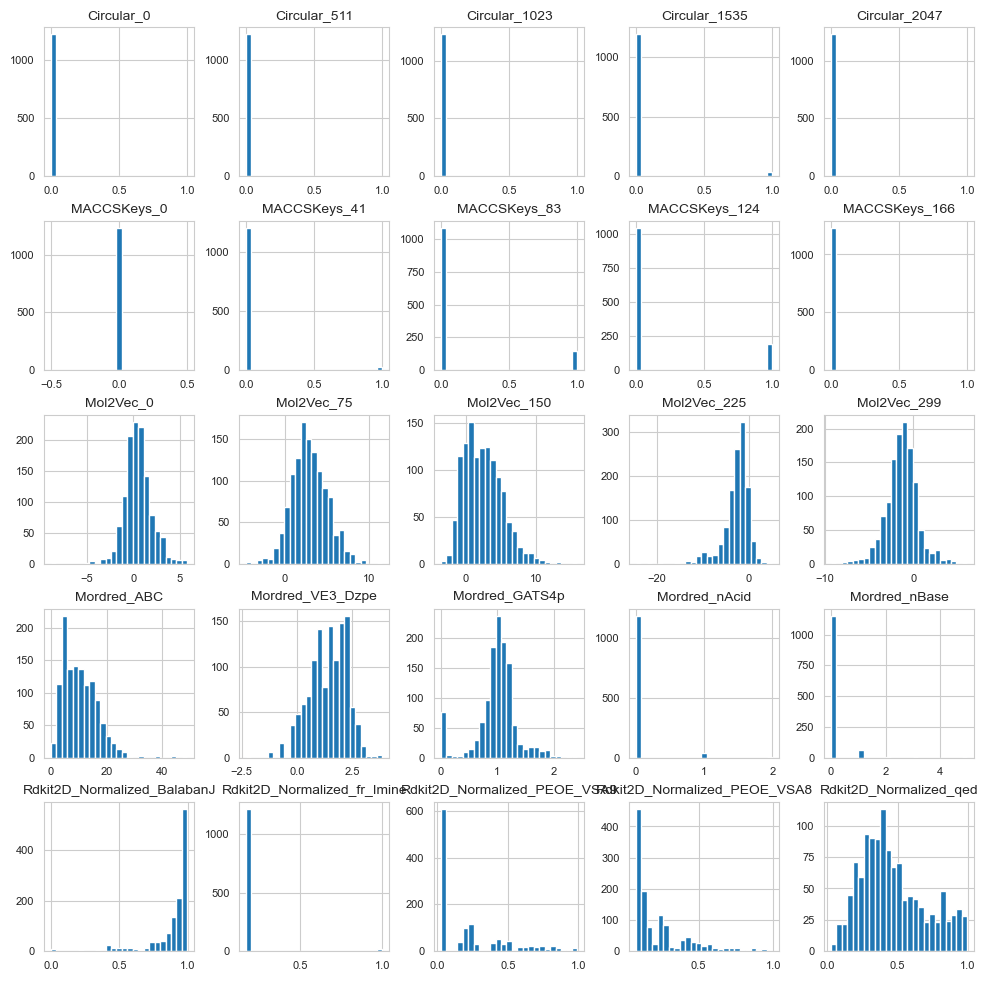

In [85]:
visualize_feats_distribution(TRN_X)

Analysis of the feature distribution revealed an approximate upper and lower limit of the data, with little to no presence of outliers. In the case of continuous variables, data points were found to be uniformly distributed throughout the range. Therefore, to standardize the feature values, we utilized the Min-Max scaler to convert them from their natural range to a standardized range. One-hot encoded feature values, such as Extended-Connectivity Fingerprints (Circular), were not affected by the scaler because their scaling range was set to 0-1.

In [86]:
def min_max_scale(X):
    """
    Perform Min-Max Scaling to X.
    :param X: Dataframe
    :return: Scaled dataframe
    """
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaled = pd.DataFrame(scaler.fit_transform(X))
    scaled.columns = X.columns
    return scaled

In [87]:
print(f"TRN has missing values: {True in TRN_X.isnull().sum() != 0}")

TRN has missing values: False


In [88]:
TRN_X = min_max_scale(TRN_X)
TST_X = min_max_scale(TST_X)

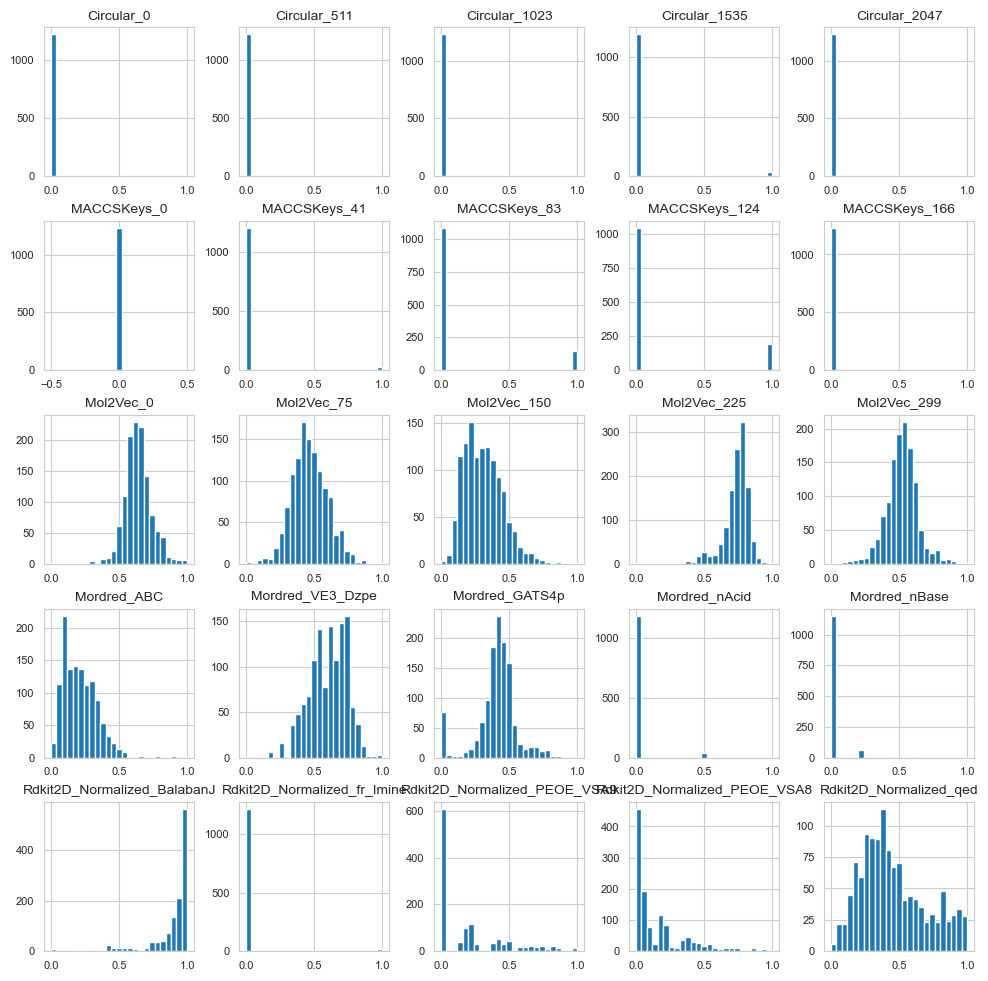

In [89]:
visualize_feats_distribution(TRN_X)

In [90]:
TRN.X = TRN_X
TST.X = TST_X

In [91]:
TRN.save_csv("ds/TRN_All")
TST.save_csv("ds/TST_All")

In [3]:
TRN = Dataset.load_csv("ds/TRN_All")
TST = Dataset.load_csv("ds/TST_All")

### Distribution of Solubility

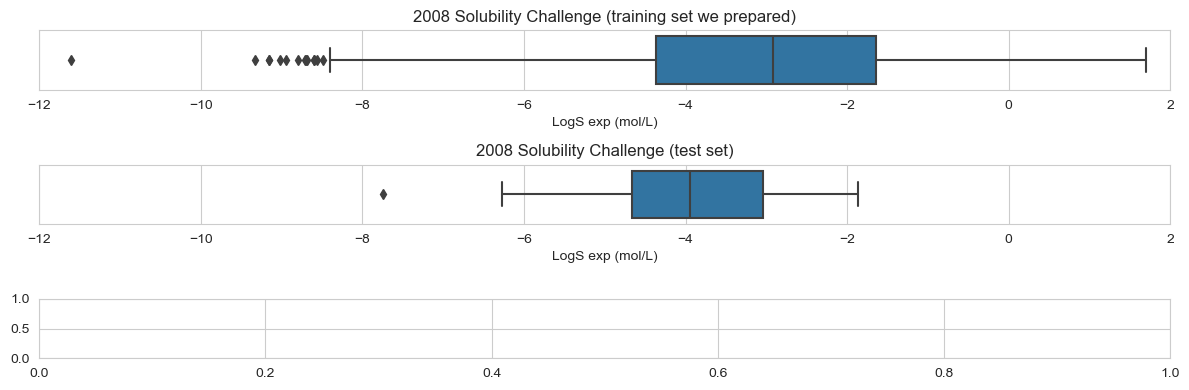

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 4))
sns.boxplot(x=TRN.y["LogS exp (mol/L)"], ax=ax1)
sns.boxplot(x=TST.y["LogS exp (mol/L)"], ax=ax2)

ax1.set_title("2008 Solubility Challenge (training set we prepared)")
ax2.set_title("2008 Solubility Challenge (test set)")

ax1.set_xlim(-12, 2)
ax2.set_xlim(-12, 2)
fig.tight_layout()

## 7 Dimensionality Reduction

Feature selection and dimensionality reduction are techniques in machine learning and data analysis that aim to reduce the number of features in a dataset. Feature selection involves selecting the most relevant subset of features without modifying the original dataset. In contrast, dimensionality reduction transforms the original features into a lower-dimensional space while preserving as much information as possible.

Dimensionality reduction is a crucial step in data analysis as it can also help address the challenges mentioned in the previous section. Both feature selection and dimensionality reduction techniques aim to reduce the dimensionality of data. Feature selection is useful when there is prior knowledge about which features are relevant to the problem. However, it may only sometimes capture the underlying structure of the data. In contrast, dimensionality reduction can capture this structure and reveal hidden patterns in the data. Again, however, it may sometimes be unclear which technique to use or the number of dimensions to reduce the data to.

Uniform Manifold Approximation and Projection (UMAP) is a powerful nonlinear dimensionality reduction technique designed to preserve the underlying structure of high-dimensional data in a lower-dimensional space, similar to t-Distributed Stochastic Neighbor Embedding (t-SNE). However, UMAP achieves this goal by constructing a topological representation of the data, approximating the high-dimensional data as a Riemannian manifold.

Becht et al. suggested that UMAP is preferable to t-SNE due to its better ability to preserve the global structure of the data and provide more consistent results across multiple runs.

Another critical advantage of UMAP over other dimensionality reduction techniques is its ability to handle large datasets with high dimensionality, which is crucial for our large datasets. Additionally, UMAP is highly flexible, with various parameters that can be adjusted to control the balance between preserving local and global structure in the data.

Therefore, we select UMAP as the dimensionality reduction method to compare with feature selection.

Firstly, we set the dimensionality of the embedding space to 2 to facilitate straightforward visualization. This does a useful job of capturing the structure of the data.

In [6]:
import umap
import umap.plot
import matplotlib.pyplot as plt

umap_n_neighbors = 15
mapper = umap.UMAP(n_components=2, n_neighbors=umap_n_neighbors).fit(TRN.X, TRN.y)
embedding = mapper.transform(TRN.X)

Text(0.5, 1.0, 'Connectivity in The Manifold\n2008 Solubility Challenge')

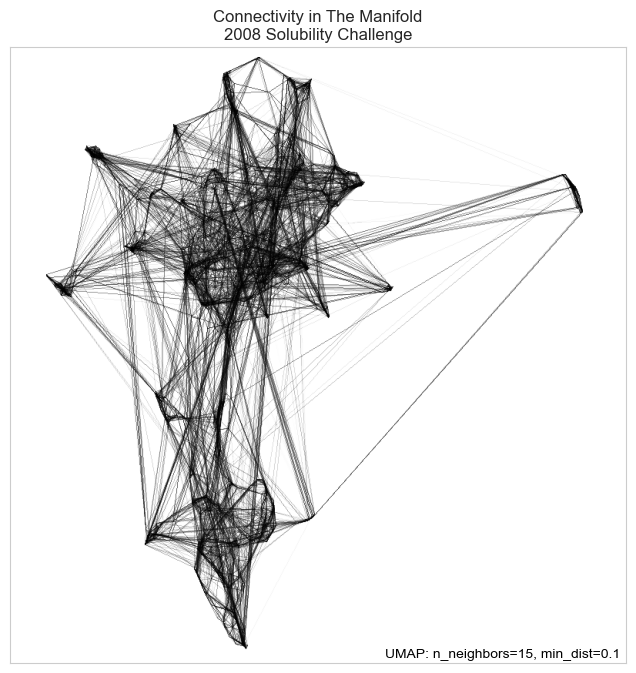

In [7]:
umap.plot.connectivity(mapper)
plt.title("Connectivity in The Manifold\n2008 Solubility Challenge")

C:\Users\ecbur\Desktop\BASE\SDK\Conda\envs\StA4099\lib\site-packages\umap\plot.py:885: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(


Text(0.5, 1.0, 'Connectivity in The Manifold (edge-bundling)\n2008 Solubility Challenge')

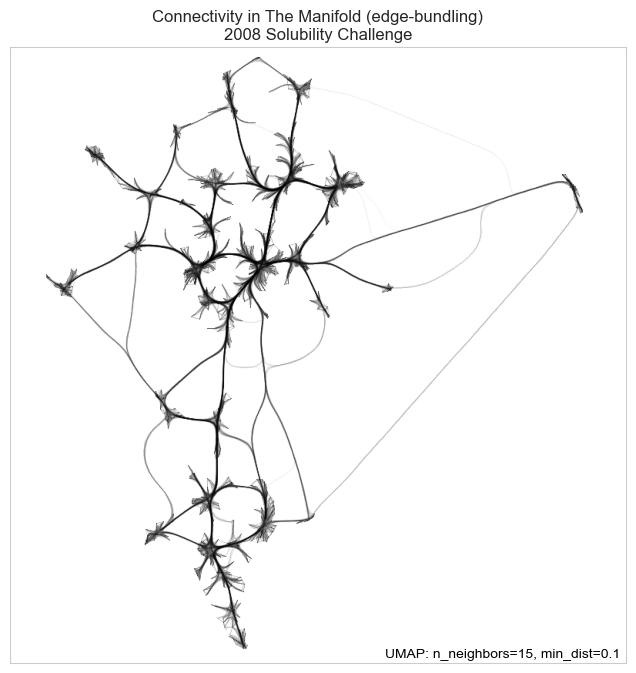

In [8]:
umap.plot.connectivity(mapper, edge_bundling='hammer')
plt.title("Connectivity in The Manifold (edge-bundling)\n2008 Solubility Challenge")

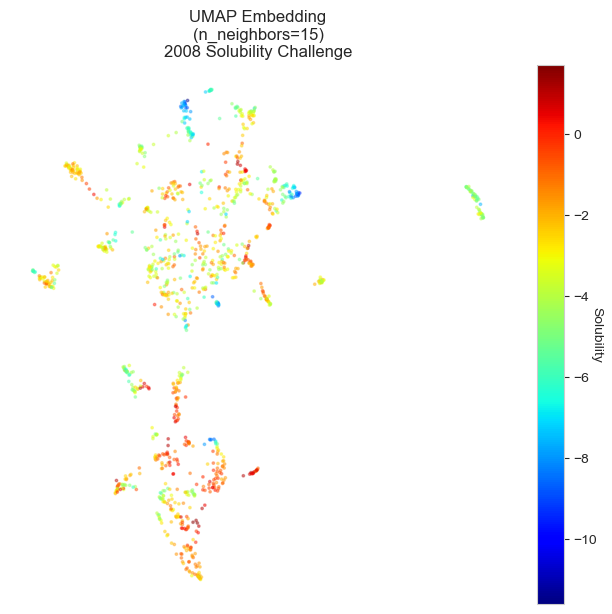

In [9]:
import matplotlib

fig, ax = matplotlib.pyplot.subplots(figsize=(8, 7))
sct = matplotlib.pyplot.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=TRN.y.values,
    s=3,
    alpha=0.4,
    cmap=matplotlib.cm.get_cmap("jet"),
)
matplotlib.pyplot.axis('off')
cbar = fig.colorbar(sct)
cbar.solids.set(alpha=1)  # Solid Color Bar
cbar.ax.set_ylabel('Solubility', rotation=270)
matplotlib.pyplot.title(f"UMAP Embedding\n"
                        f"(n_neighbors={umap_n_neighbors})\n"
                        f"2008 Solubility Challenge")

We then select a higher-dimensional embedding space for training, with a dimensionality closer to that of the underlying manifold on which the actual data resides. (i.e., `n_components=50` and `n_components=100`)

In [10]:
ALL_X = pd.concat([TRN.X, TST.X])
ALL_y = pd.concat([TRN.y, TST.y])

In [11]:
reducer_50d = umap.UMAP(n_components=50, n_neighbors=15)
embedding_50d = reducer_50d.fit_transform(ALL_X.fillna(0), ALL_y)

In [15]:
Dataset(X=pd.DataFrame(embedding_50d[:len(TRN)]), y=TRN.y, ID=TRN.ID).save_csv("ds/UMAP_50d_TRN")
Dataset(X=pd.DataFrame(embedding_50d[len(TRN):len(TRN) + len(TST)]), y=TST.y, ID=TST.ID).save_csv(
    "ds/UMAP_50d_TST")

In [16]:
reducer_100d = umap.UMAP(n_components=100, n_neighbors=15)
embedding_100d = reducer_100d.fit_transform(ALL_X.fillna(0), ALL_y)

In [17]:
Dataset(X=pd.DataFrame(embedding_100d[:len(TRN)]), y=TRN.y, ID=TRN.ID).save_csv("ds/UMAP_100d_TRN")
Dataset(X=pd.DataFrame(embedding_100d[len(TRN):len(TRN) + len(TST)]), y=TST.y, ID=TST.ID).save_csv(
    "ds/UMAP_100d_TST")

## 8 Feature Importance

Inputting all features into the ML model is generally not a good idea because every new feature adds a new dimension, making the valuable data sparse. The sparser the input data, the more complicated it is for a model to learn the relationship between the features that matter and the label. Not all generated descriptors benefit the solubility prediction, so having all of them is of no use - a quality data set is the prioritised factor to succeed in the problem.

Feature importance is a measure that indicates how much each feature contributes to the overall prediction of a machine learning model, where we remove unimportant features to simplify the model and reduce over-fitting. However, feature importance is not equivalent to the intrinsic predictive value of a feature by itself, and features that we consider less important may have higher importance for a good model; thus, we cross-validate our models' performance before computing importance.

We use a XGBoost model to evaluate the importance of features.

In [4]:
from model.xgboost.XGBoost import XGBoost

MODEL = XGBoost(
    task_type="regression",
    n_estimators=300,
    learning_rate=0.1,
    subsample=0.36,
    reg_alpha=0.3,
    gamma=0.3,
    grow_policy="lossguide",
)
MODEL.fit(TRN)
# MODEL.fit(TRN, eval_set=[(TST.X, TST.y)])

[INFO] Expect to use 'Any Tabular Descriptor' to featurize SMILES


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.3, gpu_id=None, grow_policy='lossguide',
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None, ...)

### 8.1 Permutation Based Feature Importance

We use permutation variable importance, a model inspection technique that evaluates the increase in the prediction error of a model after permuting the feature’s values. When we randomly shuffle a single feature value, the decrease in a model score is the permutation feature importance. The drop in the model score reasonably indicates how much the model depends on the feature because the procedure breaks the relationship between the feature and the label. It benefits from being model agnostic and can be calculated many times with different feature permutations.

In [ ]:
from sklearn.inspection import permutation_importance

perm_importance_TST = permutation_importance(MODEL.model, TST.X, TST.y)

The computation would be time-consuming.
Save the computed permutation importance data to local.

In [20]:
import pickle

file_path_tst = "fi/Permutation-Feature-Importance-TST.pkl"

In [132]:
with open(file_path_tst, "wb") as f:
    pickle.dump(perm_importance_TST, f)

In [21]:
with open(file_path_tst, "rb") as f:
    perm_importance_TST = pickle.load(f)

The visualization of the permutation-based importance:

In [22]:
N = int(input("Select top N important features to plot.\nN = "))

topN_feats_tst_idx = lambda N: perm_importance_TST.importances_mean.argsort()[::-1][:N]
topN_tst_idx = topN_feats_tst_idx(N)
topN_tst_feats = perm_importance_TST.importances_mean[topN_tst_idx]

In [23]:
print(f"TST: Select Top {N}: {min(topN_tst_feats)} ~ {max(topN_tst_feats)}")

TST: Select Top 20: 0.010913256265812344 ~ 0.1425650187835313


Text(0.5, 1.0, 'Permutation Feature Importance - 2008 Solubility Challenge')

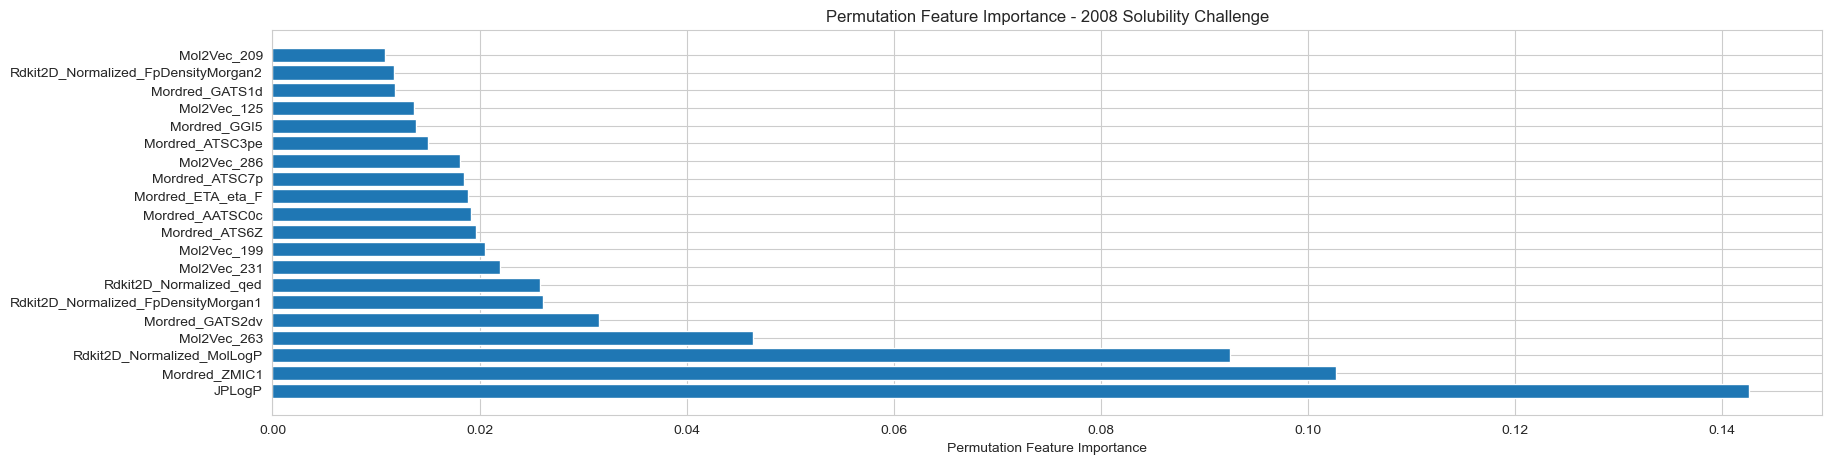

In [24]:
import matplotlib

_, (ax1) = matplotlib.pyplot.subplots(figsize=(20, 5))
ax1.barh(TRN.X.columns[topN_tst_idx], topN_tst_feats)
ax1.set_xlabel("Permutation Feature Importance")
ax1.set_title("Permutation Feature Importance - 2008 Solubility Challenge")

Text(0.5, 1.0, 'Correlation of 20 Features with Highest Permutation Importance\n2008 Solubility Challenge')

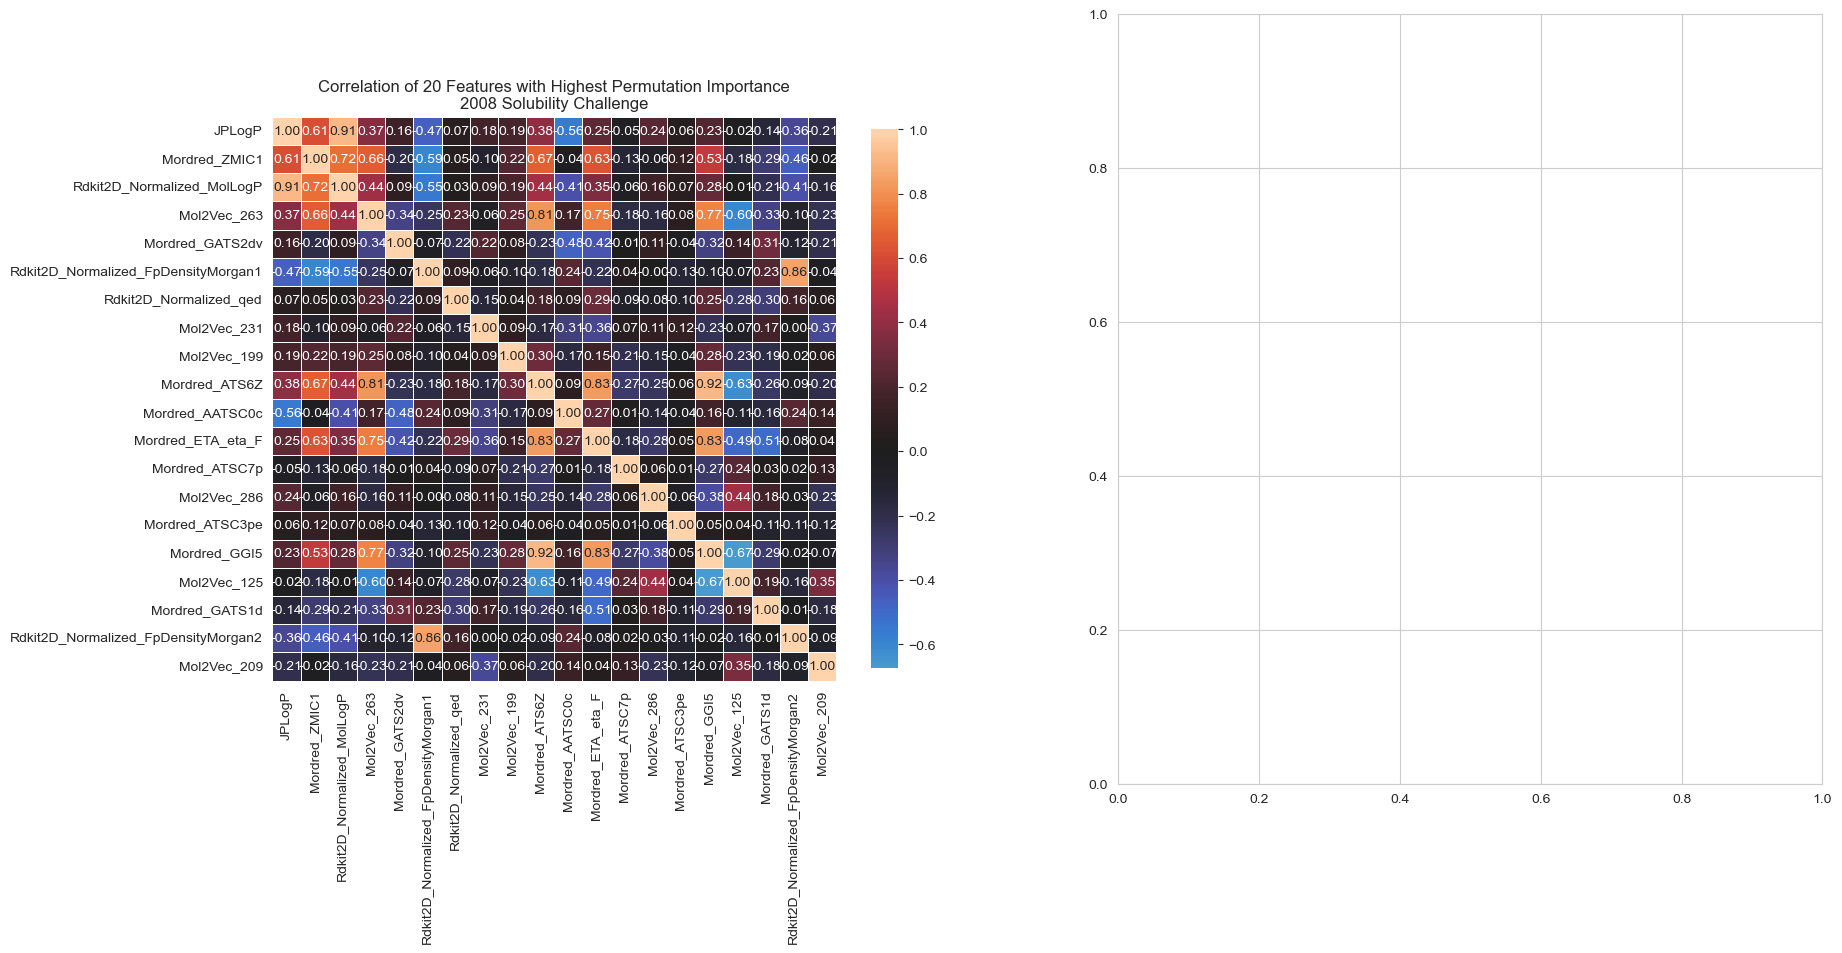

In [25]:
import seaborn as sns

_, (ax1, ax2) = matplotlib.pyplot.subplots(1, 2, figsize=(20, 10))

correlations_tst = TRN.X[TRN.X.columns[topN_tst_idx]].corr()

sns.heatmap(
    correlations_tst, vmax=1.0, center=0, fmt='.2f',
    square=True, linewidths=.5, annot=N <= 20, cbar_kws={"shrink": .70}, ax=ax1
)
ax1.set_title("Correlation of 20 Features with Highest Permutation Importance\n"
              "2008 Solubility Challenge")

In [26]:
N = int(input("Select top N important features.\nN = "))
topN_feats_tst_idx = lambda N: perm_importance_TST.importances_mean.argsort()[::-1][:N]
topN_idx = topN_feats_tst_idx(N)
topN_feats = perm_importance_TST.importances_mean[topN_idx]
f"Select Top {N}: {min(topN_feats)} ~ {max(topN_feats)}"

'Select Top 140: 0.002085609008540512 ~ 0.1425650187835313'

In [27]:
TRN_PBFI = Dataset(X=TRN.X[TRN.X.columns[topN_idx]], y=TRN.y)
TRN_PBFI.save_csv(f"ds/PBFI_{N}_TRN")

In [28]:
TST1_PBFI = Dataset(X=TST.X[TST.X.columns[topN_idx]], y=TST.y)
TST1_PBFI.save_csv(f"ds/PBFI_{N}_TST")

### 8.2 SHapley Additive exPlanations (SHAP) Feature Importance Analysis

SHapley Additive exPlanations (SHAP) Feature Importance is an alternative to permutation feature importance. The idea behind permutation feature importance is the decrease in model performance, while that behind SHAP feature importance is that features with greater absolute Shapley values are more important. The Shapley value assigns payouts to players depending on their contribution to the total payout, where players cooperate in a coalition and receive a certain profit from this cooperation. In other words, the Shapley value is the average marginal contribution of a feature value across all possible coalitions.

In [5]:
import shap

explainer = shap.TreeExplainer(MODEL.model)
shap_tst = explainer.shap_values(TST.X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Text(0.5, 1.0, 'SHAP Feature Importance - 2008 Solubility Challenge')

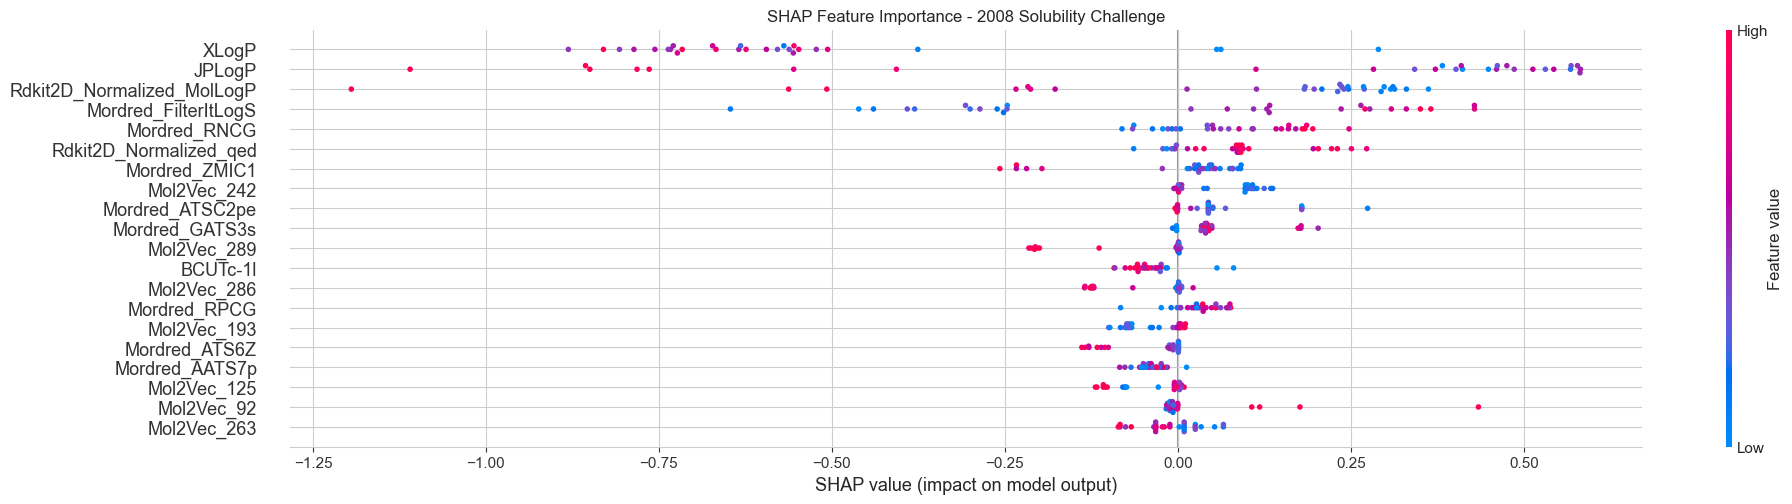

In [30]:
matplotlib.pyplot.figure(figsize=(20, 5))
ax1 = matplotlib.pyplot.subplot(1, 1, 1)
shap.summary_plot(shap_tst, TST.X, show=False, plot_size=None)
ax1.set_title("SHAP Feature Importance - 2008 Solubility Challenge")

In [6]:
def get_shap_feature_importance(shap_values):
    return np.abs(shap_values).mean(0)

In [32]:
N = int(input("Select top N important features.\nN = "))
mean_importance = np.mean(
    np.array([
        get_shap_feature_importance(shap_tst),
    ]),
    axis=0
)
topN_idx = mean_importance.argsort()[::-1][:N]
topN_feats = mean_importance[topN_idx]
f"Select Top {N}: {min(topN_feats)} ~ {max(topN_feats)}"

'Select Top 140: 0.011454669758677483 ~ 0.5965861082077026'

In [33]:
TRN_SHAP = Dataset(X=TRN.X[TRN.X.columns[topN_idx]], y=TRN.y)
TRN_SHAP.save_csv(f"ds/SHAP_{N}_TRN")

In [34]:
TST1_SHAP = Dataset(X=TST.X[TST.X.columns[topN_idx]], y=TST.y)
TST1_SHAP.save_csv(f"ds/SHAP_{N}_TST")